# 24차시: [실습] LSTM 모델을 활용한 주가 예측

## 학습 목표
- 실제 주가 데이터로 LSTM 모델 구축
- 시계열 데이터 전처리 및 스케일링
- 모델 학습, 평가, 예측 수행

## 학습 내용
1. 주가 데이터 수집 (FinanceDataReader)
2. 데이터 전처리
3. LSTM 모델 구축
4. 학습 및 평가
5. 예측 결과 분석

## 중요 주의사항 (Warning)

본 교재와 실습에서 사용하는 모든 데이터, 모델, 기법은
오직 딥러닝·LSTM 개념 이해와 교육 목적을 위한 예제입니다. 따라서,
실제 금융 시장의 복잡성, 리스크, 거래 비용, 정책·심리 요인 등을 전혀 반영하지 못하며, 실제 투자 판단이나 매매 전략에 사용해서는 안 됩니다.

실습 결과는 "참고용·학습용"으로만 활용하시기 바랍니다.

In [1]:
!pip install -Uq finance-datareader koreanize-matplotlib

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import koreanize_matplotlib
from datetime import datetime, timedelta
from IPython.display import display

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input
from sklearn.preprocessing import MinMaxScaler

---
## 1. 주가 데이터 수집

In [3]:
import FinanceDataReader as fdr

# 날짜 설정 (최근 2년)
end_date = datetime.now()
start_date = end_date - timedelta(days=730)

print("[데이터 수집]")
print("=" * 50)
print(f"기간: {start_date.strftime('%Y-%m-%d')} ~ {end_date.strftime('%Y-%m-%d')}")
print("종목: 삼성전자 (005930)")

# 삼성전자 주가 데이터
df = fdr.DataReader("005930", start_date, end_date)

df = df.reset_index()
df.columns = ['날짜', '시가', '고가', '저가', '종가', '거래량', '등락률']

print(f"\n수집된 데이터: {len(df)}개")
df.tail()

[데이터 수집]
기간: 2024-01-10 ~ 2026-01-09
종목: 삼성전자 (005930)

수집된 데이터: 485개


,날짜,시가,고가,저가,종가,거래량,등락률
480,2026-01-05,134600,138600,133600,138100,42863376,0.074708
481,2026-01-06,135300,139300,132700,138900,45321341,0.005793
482,2026-01-07,143500,144400,137600,141000,46317413,0.015119
483,2026-01-08,138300,144500,138300,138800,41449329,-0.015603
484,2026-01-09,136000,140700,135200,139000,29514279,0.001441


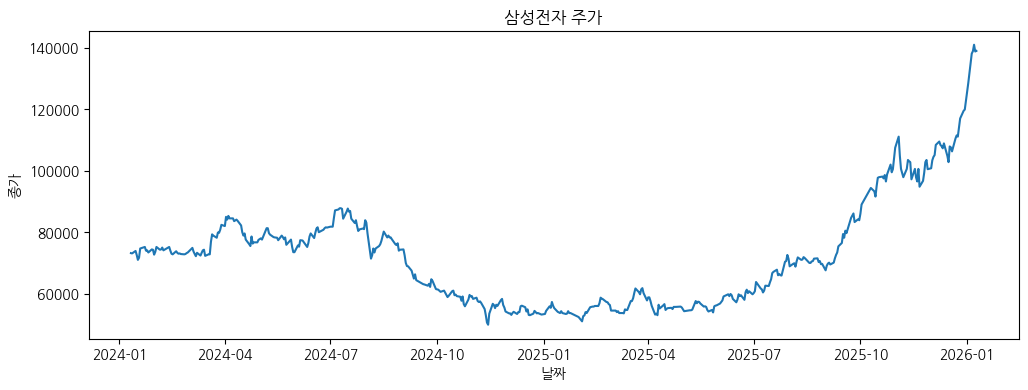

In [4]:
# 종가 시각화
fig, ax = plt.subplots(figsize=(12, 4))
ax.plot(df['날짜'], df['종가'])
ax.set_xlabel('날짜')
ax.set_ylabel('종가')
ax.set_title('삼성전자 주가')
plt.show()

---
## 2. 데이터 전처리

### LSTM 입력 형태
- `(samples, timesteps, features)`
- samples: 학습 샘플 수
- timesteps: 시퀀스 길이 (과거 몇 일?)
- features: 특성 수 (종가만 사용시 1)

In [5]:
# 종가 데이터 추출
close_prices = df['종가'].values.reshape(-1, 1)
close_prices.shape

(485, 1)

In [6]:
# MinMaxScaler로 0~1 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(close_prices)

In [7]:
# 시퀀스 데이터 생성
def create_sequences(data, seq_length):
    """
    과거 seq_length 일의 데이터로 다음날 종가를 예측하는 시퀀스 생성
    """
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

# 시퀀스 길이 설정
SEQ_LENGTH = 20  # 과거 20일(약 1 개월) 데이터 사용

X, y = create_sequences(scaled_data, SEQ_LENGTH)

print(f"[시퀀스 데이터]")
print("=" * 50)
print(f"X shape: {X.shape} (샘플, 시퀀스길이, 특성)")
print(f"y shape: {y.shape}")

[시퀀스 데이터]
X shape: (465, 20, 1) (샘플, 시퀀스길이, 특성)
y shape: (465, 1)


In [8]:
# 학습/테스트 분할 (시계열이므로 순서 유지)
train_size = int(len(X) * 0.8)

X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"\n[데이터 분할]")
print("=" * 50)
print(f"학습 데이터: {len(X_train)}개")
print(f"테스트 데이터: {len(X_test)}개")


[데이터 분할]
학습 데이터: 372개
테스트 데이터: 93개


---
## 3. LSTM 모델 구축

In [9]:
# LSTM 모델 정의
model = Sequential([
    Input(shape=(SEQ_LENGTH, 1)),
    LSTM(units=50),
    Dense(units=25, activation='relu'),
    Dense(units=1)
])

# 컴파일
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

print("[LSTM 모델 구조]")
print("=" * 50)
model.summary()

[LSTM 모델 구조]


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,701 (45.71 KB)

 Trainable params: 11,701 (45.71 KB)

 Non-trainable params: 0 (0.00 B)

---
## 4. 학습 및 평가

In [10]:
# 모델 학습
history = model.fit(
    X_train, y_train, epochs=100, batch_size=32, validation_split=0.1
)

print(f"\n학습 완료! (Epochs: {len(history.history['loss'])})")

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0457 - mae: 0.1675 - val_loss: 0.0110 - val_mae: 0.0992
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0110 - mae: 0.0767 - val_loss: 0.0012 - val_mae: 0.0291
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0050 - mae: 0.0623 - val_loss: 0.0010 - val_mae: 0.0273
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0027 - mae: 0.0434 - val_loss: 8.1637e-04 - val_mae: 0.0230
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0013 - mae: 0.0286 - val_loss: 0.0021 - val_mae: 0.0417
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 9.7028e-04 - val_mae: 0.0248
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 9.7627e-04 - mae: 0.0232 - val_loss: 0.0012 - val_mae: 0.0282
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 8.4396e-04 - mae: 0.0222 - val_loss: 0.0014 - val_mae: 0.0317
Epoch 9/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0

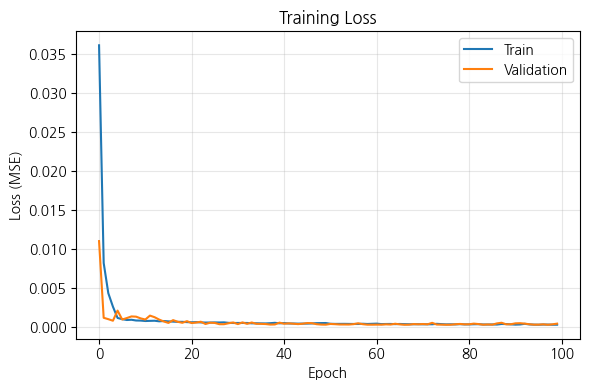

In [11]:
# 학습 곡선 시각화
plt.figure(figsize=(6, 4))

# Train / Validation Loss
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')

# 그래프 설정
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.title('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
# 테스트 데이터 예측
y_pred_scaled = model.predict(X_test)

# 역정규화 (원래 가격으로 변환)
y_pred = scaler.inverse_transform(y_pred_scaled)
y_actual = scaler.inverse_transform(y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


---
## 5. 예측 결과 분석

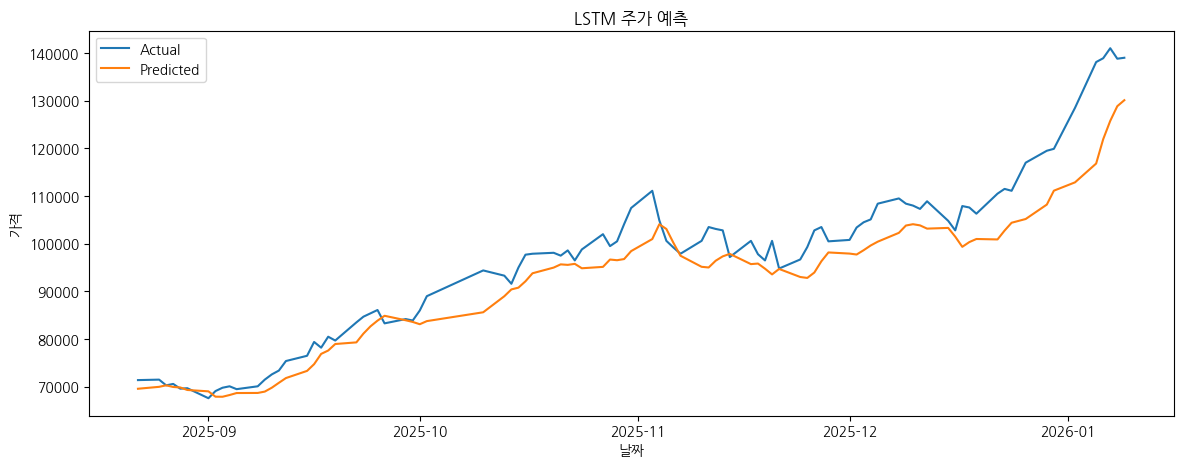

In [13]:
# 테스트 기간 날짜
test_dates = df['날짜'].iloc[train_size + SEQ_LENGTH:].values

# 예측 결과 시각화
plt.figure(figsize=(14, 5))

# 실제값 vs 예측값
plt.plot(test_dates, y_actual, label='Actual')
plt.plot(test_dates, y_pred, label='Predicted')

# 그래프 설정
plt.xlabel('날짜')
plt.ylabel('가격')
plt.title(f'LSTM 주가 예측')
plt.legend()
plt.show()

---
## 미래 주가 예측 (참고)

In [14]:
# 마지막 20일 데이터로 다음날 예측
last_sequence = scaled_data[-SEQ_LENGTH:].reshape(1, SEQ_LENGTH, 1)
next_day_scaled = model.predict(last_sequence)
next_day_price = scaler.inverse_transform(next_day_scaled)[0, 0]

print("[다음 거래일 예측]")
print("=" * 50)
print(f"마지막 종가: {df['종가'].iloc[-1]:,}원")
print(f"다음날 예측가: {next_day_price:,.0f}원")

print("\n주의: 이는 단순 예측이며 투자 조언이 아닙니다.")
print("주가 예측은 매우 어려우며 과거 데이터가 미래를 보장하지 않습니다.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[다음 거래일 예측]
마지막 종가: 139,000원
다음날 예측가: 130,005원

주의: 이는 단순 예측이며 투자 조언이 아닙니다.
주가 예측은 매우 어려우며 과거 데이터가 미래를 보장하지 않습니다.


---
## 학습 정리

### 1. LSTM 주가 예측 파이프라인
```
데이터 수집 → 정규화 → 시퀀스 생성 → 모델 학습 → 예측 → 역정규화
```

### 2. 주의사항
- 주가 예측은 매우 어려운 문제
- 과적합 주의
- 다양한 특성 추가 고려 (거래량, 기술적 지표)
- 모델 성능이 좋아도 실제 투자에는 주의

---

### 다음 차시 예고
- 25차시: 자연어 처리(NLP) 기초
  - 텍스트 전처리 (토큰화)
  - TF-IDF, Word2Vec 개념
  - 금융 텍스트 분석 준비